# Рекуррентные сети

Цели:

- Реализация RNN from scratch
- Реализация LSTM from scratch
- Сеть на основе LSTM-ячейки из pytorch

Содержание:

* [Введение](#intro)
* [Загрузка данных](#load_data)
* [Введение в рекуррентные сети](#rnn_intro)
  * [Цикл обучения RNN](#rnn_train_loop)
  * [Недостатки "ванильных" RNN](#vanilla_rnn)
* [Рекуррентные сети с памятью](#lstm)
  * [Цикл обучения LSTM](#lstm_train_loop)
* [Pytorch LSTM Cell](#pytorch_lstm)
  * [Цикл обучения](#lstm2_train_loop)


Ссылки:

* [Pytorch RNN char generation tutorial](https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html)
* [Understanding LSTM Networks, C. Olah blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) и её [перевод](https://habr.com/ru/companies/wunderfund/articles/331310/)
* [Долгая краткосрочная память (вики ИТМО)](https://neerc.ifmo.ru/wiki/index.php?title=%D0%94%D0%BE%D0%BB%D0%B3%D0%B0%D1%8F_%D0%BA%D1%80%D0%B0%D1%82%D0%BA%D0%BE%D1%81%D1%80%D0%BE%D1%87%D0%BD%D0%B0%D1%8F_%D0%BF%D0%B0%D0%BC%D1%8F%D1%82%D1%8C)
* [Использовались материалы ДЗ с прекрасного курса по NLP от Яндекса](https://github.com/yandexdataschool/nlp_course/blob/2023/week03_lm/homework_pytorch.ipynb)

<a name="intro"></a>
## Введение

В качестве последовательностей в данном ноутбуке будем использовать тексты  работ с arXiv (название + аннотация), которые связаны с генеративным моделированием. Датасет вместе с кодом его создания находится на [huggingface hub](https://huggingface.co/datasets/sswt/arxiv_sample_50K/tree/main).

Будем рассматривать текст, как последовательность символов.
<p align="center">
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w4/meme_text_sequence.png" alt="Text sequence" width="40%">
</p>



In [ ]:
import time
import math
import torch
import random
import string
import unicodedata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicode2ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# One-hot matrix of first to last letters for input (w/o EOS)
def input_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# Label-encoded matrix fo first to last letters for altenative input
def label_tensor(line):
    t = torch.LongTensor([all_letters.find(line[li]) for li in range(len(line))])
    return t.unsqueeze(-1)  # to keep size consistent with input tensor

# LongTensor of second letter to end (EOS) for target
def target_tensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(all_letters.find(EOS)) # EOS
    return torch.LongTensor(letter_indexes)

# Get a random line excluding EOS
def random_training_line():
    line = lines[random.randint(0, len(lines) - 1)]
    return line[:-1]

# Make category, input, and target tensors from a random category, line pair
def random_training_example():
    line = random_training_line()
    input_line_tensor = input_tensor(line)
    target_line_tensor = target_tensor(line)
    return input_line_tensor, target_line_tensor

# Measure time in human format
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

<a name="load_data"></a>
## Загрузка данных

In [2]:
all_letters = ''.join(sorted(string.ascii_letters + "1234567890" + " .,;'\n"))
n_letters = len(all_letters)

In [3]:
!wget https://huggingface.co/datasets/sswt/arxiv_sample_50K/resolve/main/arxiv_sample.tar.gz -O arxivData.json.tar.gz
!tar -xvzf arxivData.json.tar.gz

--2023-10-05 10:53:40--  https://huggingface.co/datasets/sswt/arxiv_sample_50K/resolve/main/arxiv_sample.tar.gz
Resolving huggingface.co (huggingface.co)... 13.224.2.18, 13.224.2.92, 13.224.2.115, ...
Connecting to huggingface.co (huggingface.co)|13.224.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/de/1c/de1c0f222f07c7a4b536714d5eb85c5009aa7c9778ab92a1ac4959c40d68f014/c349af0e40b375c53d04b9a77745f9ed7f4a87012f9558f20b72c3a5691c1254?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27arxiv_sample.tar.gz%3B+filename%3D%22arxiv_sample.tar.gz%22%3B&response-content-type=application%2Fgzip&Expires=1696762420&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5Njc2MjQyMH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9kZS8xYy9kZTFjMGYyMjJmMDdjN2E0YjUzNjcxNGQ1ZWI4NWM1MDA5YWE3Yzk3NzhhYjkyYTFhYzQ5NTljNDBkNjhmMDE0L2MzNDlhZjBlNDBiMzc1YzUzZDA0YjlhNzc3N

In [4]:
data = pd.read_json("./arxiv_sample.json")
print(data.shape)
data.sample(n=3)

(50000, 5)


,title,published,authors,summary,link
12280,Principal Lyapunov exponents and principal Flo...,2012-09-16,"[Janusz Mierczyński, Wenxian Shen]",This is the first of a series of papers concer...,http://arxiv.org/abs/1209.3475v3
36442,Pebbling Arguments for Tree Evaluation,2013-11-01,[David Liu],The Tree Evaluation Problem was introduced by ...,http://arxiv.org/abs/1311.0293v1
35903,Cross-Modality Time-Variant Relation Learning ...,2023-05-15,"[Jingyi Wang, Jinfa Huang, Can Zhang, Zhidong ...",Dynamic scene graphs generated from video clip...,http://arxiv.org/abs/2305.08522v1


In [5]:
seq_len = 256  # to prevent RNN gradients from exploding
BOS, EOS = ' ', '\n'  # special tokens for generation

# EOS will be added only for targets
lines = data.apply(lambda row: unicode2ascii((row['title'] + ' ; ' + row['summary'])[:seq_len]), axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ')) \
            .tolist()

In [6]:
data['summary'].apply(lambda x: len(x)).describe()

count    50000.000000
mean      1018.268420
std        401.231211
min         18.000000
25%        695.000000
50%       1033.000000
75%       1299.000000
max       2902.000000
Name: summary, dtype: float64

In [6]:
lines, dev_lines = train_test_split(lines, test_size=.2, random_state=42)

In [7]:
lines[:3]

[' Nonlinear matter power spectrum without screening dynamics modelling in fR gravity ; Halo model is a physically intuitive method for modelling the nonlinear power spectrum, especially for the alternatives to the standard LambdaCDM models. In this ',
 ' Hybrid SymbolicNumeric Framework for Power System Modeling and Analysis ; With the recent proliferation of opensource packages for computing, power system differentialalgebraic equation DAE modeling and simulation are being revisited to reduce the pro',
 ' PT symmetry, Cartan decompositions, Lie triple systems and Krein space related Clifford algebras ; Gauged PT quantum mechanics PTQM and corresponding Krein space setups are studied. For models with constant nonAbelian gauge potentials and extended parit']

In [8]:
line = random_training_line()
input_line_tensor = input_tensor(line)
target_line_tensor = target_tensor(line)
label_line_tensor = label_tensor(line)
print(line[:128])
print(input_line_tensor.shape)
print(target_line_tensor[-10:])
target_line_tensor = target_line_tensor.unsqueeze(-1)

 GAP Learning to generate targetconditioned adversarial examples ; Adversarial examples are perturbed inputs which can cause a s
torch.Size([252, 1, 68])
tensor([ 1, 50, 61, 46, 59, 42, 61, 50, 63,  0])


<a name="rnn_intro"></a>
## RNN

Recurrent Neural Networks

<figure>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" alt="Forward vs Reverse KL" style="width:100%">
<figcaption align = "center"> Image credit: <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Colah's blog</a></figcaption>
</figure>

Рекуррентные нейросети на $t$-ом шаге принимают на вход элемент последовательности $x_t$, а возвращают $h_t$, который поступает на вход на следующем шаге вместе с $x_{t+1}$. Звучит как какая-то магия. Можно представить такую аналогию, что у нас как бы несколько копий одной сетки, каждая из которых передаёт сообщение следующей по цепочке. Это становится более наглядным, если развернуть цикл, как на картинке.

In [9]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.nonlinear = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        input_combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output_combined = self.nonlinear(output_combined)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self, device=torch.device('cpu')):
        return torch.zeros(1, self.hidden_size).to(device)

In [15]:
rnn = RNN(n_letters, 128, n_letters)
hidden = rnn.init_hidden()
criterion = nn.NLLLoss()
for i in range(input_line_tensor.size(0)):
      output, hidden = rnn(input_line_tensor[i], hidden)
      l = criterion(output, target_line_tensor[i])

In [16]:
l, target_line_tensor[i], output[0, target_line_tensor[i][0]]

(tensor(4.2915, grad_fn=<NllLossBackward0>),
 tensor([0]),
 tensor(-4.2915, grad_fn=<SelectBackward0>))

Добавим типовой код для обучения и генерации

In [17]:
def train(model, opt, input_line_tensor, target_line_tensor, hidden, add_dim=False):
    target_line_tensor.unsqueeze_(-1)

    # model.zero_grad()
    opt.zero_grad()

    loss = torch.Tensor([0]).to(device) # you can also just simply use ``loss = 0``
    hidden_hist = []
    for i in range(input_line_tensor.size(0)):
        t = input_line_tensor[i]
        if add_dim:  # for nn.LSTM we need and extra dimension
            t = t.unsqueeze(0)
        output, hidden = model(t, hidden)
        l = criterion(output, target_line_tensor[i])
        if torch.isnan(l):
          print('OOPS:', i, hidden, output)
          raise
        loss += l
    loss.backward()

    # for p in model.parameters():
    #     p.data.add_(p.grad.data, alpha=-learning_rate)
    opt.step()

    return output, loss.item() / input_line_tensor.size(0)

In [18]:
# Sample from a category and starting letter
def sample(model, start_letter='A', device=torch.device('cpu'), add_dim=False, temperature=None):
    """
    add_dim - for case of nn.LSTM with Embedding layer over label-encoded input
    """
    with torch.no_grad():  # no need to track history in sampling
        tensor_func = input_tensor if not add_dim else label_tensor
        input = tensor_func(start_letter).to(device)
        hidden = model.init_hidden(device=device)
        output_name = start_letter

        for i in range(seq_len):
            t = input[0]
            if add_dim:  # for nn.LSTM we need and extra dimension
                t = t.unsqueeze(0)
            output, hidden = model(t, hidden)
            if temperature is None:
                topv, topi = output.topk(1)
                topi = topi[0][0]
                if topi == n_letters - 1:
                    break
                else:
                    letter = all_letters[topi]
                    output_name += letter
            else:
                probs = torch.exp(output).detach().clone().flatten().cpu().numpy()**(1/temperature)
                probs /= probs.sum()
                letter = np.random.choice(list(all_letters), p=probs)
                if letter == all_letters[-1]:
                    break
                else:
                    output_name += letter
            input = tensor_func(letter).to(device)

        return output_name

# Get multiple samples from one category and multiple starting letters
def samples(model, start_letters='ABC', device=torch.device('cpu'), add_dim=False, temperature=None):
    for start_letter in start_letters:
        print(sample(model, start_letter, device, add_dim, temperature=temperature))

<a name="rnn_train_loop"></a>
### RNN цикл обучения

In [14]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [15]:
criterion = nn.NLLLoss()
learning_rate = 0.0005
model_rnn = RNN(n_letters, 128, n_letters).to(device)
opt = torch.optim.Adam(model_rnn.parameters(), lr=learning_rate)

In [16]:
samples(model_rnn, [' '])

 iW9dLhGaC W1FM1Im49ULSCuKX1SOB5uyW mjD


Здесь можно обратить внимание, что сетка очень не стабильна и если увеличить максимальную длину последовательности (с 256 до 512 например) или увеличить вдвое learning_rate, градиенты начинают взрываться почти всегда. При текущих параметрах это происходит лишь иногда.

In [17]:
n_iters = 15000
print_every = 50 * 4
plot_every = 50
all_losses_rnn = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    x, y = random_training_example()
    hidden = model_rnn.init_hidden().to(device)
    output, loss = train(model_rnn, opt, x.to(device), y.to(device), hidden)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_rnn.append(total_loss / plot_every)
        total_loss = 0

0m 21s (200 1%) 3.1292
0m 50s (400 2%) 3.0704
1m 13s (600 4%) 2.6915
1m 33s (800 5%) 2.4314
1m 54s (1000 6%) 2.4089
2m 14s (1200 8%) 2.4322
2m 33s (1400 9%) 2.5105
2m 53s (1600 10%) 2.5062
3m 13s (1800 12%) 2.5027
3m 34s (2000 13%) 2.3250
3m 54s (2200 14%) 2.5537
4m 14s (2400 16%) 2.6619
4m 34s (2600 17%) 2.4698
4m 54s (2800 18%) 2.1004
5m 20s (3000 20%) 2.3726
5m 45s (3200 21%) 2.4216
6m 8s (3400 22%) 2.3491
6m 29s (3600 24%) 2.2328
6m 52s (3800 25%) 2.2804
7m 13s (4000 26%) 2.2309
7m 36s (4200 28%) 2.3730
7m 57s (4400 29%) 2.1637
8m 17s (4600 30%) 2.2395
8m 37s (4800 32%) 2.0108
8m 57s (5000 33%) 1.9299
9m 16s (5200 34%) 2.2629
9m 36s (5400 36%) 1.9664
9m 56s (5600 37%) 2.2740
10m 18s (5800 38%) 2.2360
10m 38s (6000 40%) 2.3094
10m 58s (6200 41%) 1.9693
11m 30s (6400 42%) 2.0323
11m 50s (6600 44%) 2.0660
12m 16s (6800 45%) 2.0239
12m 35s (7000 46%) 2.0390
12m 56s (7200 48%) 2.2817
13m 16s (7400 49%) 2.3113
13m 36s (7600 50%) 1.9855
13m 57s (7800 52%) 2.1250
14m 17s (8000 53%) 1.8854


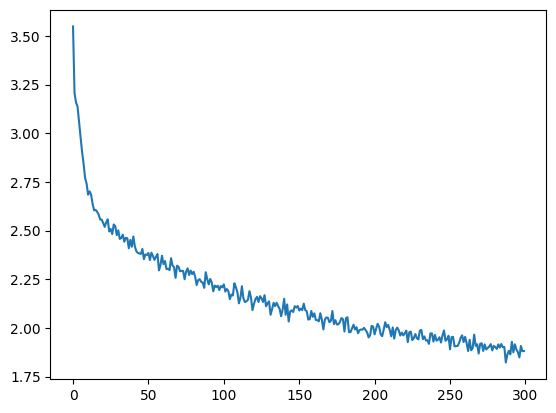

In [18]:
plt.plot(all_losses_rnn)

In [46]:
samples(model_rnn, [' '])

 A Contrative Lexical Semantic Mathing ; Whichnation oftem or and componal mathing the problem of the probles of the problem ofining and commonic learnificative compuse a mangure a detective and models formattic problem of to in there a mangured and structe


<a name="vanilla_rnn"></a>
### Недостатки "ванильных" RNN

В случаях, когда релевантный контекст, необходимый для предсказания следующего элемента последовательности находится недалеко в последовательности, RNN может использовать эту информацию.


<figure>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-shorttermdepdencies.png" alt="RNN short term dependencies" width="70%">
</figure>

Однако иногда нужно больше контекста и релевантная информация находится далеко и с ростом этого разрыва RNN становится неспособной использовать нужный контекст.

<figure>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-longtermdependencies.png" alt="RNN log term dependencies" width="70%">
<figcaption align = "center"> Image credits: <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Colah's blog</a></figcaption></figure>

<a name="lstm"></a>
## LSTM

**Long Short Term Memory Networks** (Hochreiter & Schmidhuber, 1997), сети долгой краткосрочной памяти, специально созданы для того, чтобы избежать проблемы длительных зависимостей.

<p align="center">
<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w4/meme_schmidhuber.jpg" alt="Jurgen" width="25%">
</p>


Сравним ячейки RNN и LSTM.

**RNN Cell**
<figure>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" alt="Forward vs Reverse KL" style="width:100%">
</figure>

---

**LSTM Cell**
<figure>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" alt="Forward vs Reverse KL" style="width:100%">
</figure>

---

<figure>
<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM2-notation.png" alt="Forward vs Reverse KL" width="50%">
<figcaption align = "center"> Image credits: <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Colah's blog</a></figcaption>
</figure>



Ключевая идея LSTM - состояние ячейки (cell state), горизонтальная линия, которая проходит по верху диаграммы. Она проходит по всей цепочке лишь с двумя простыми линейными преобразованиями и информации очень легко протекать через неё без изменения.

<img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-C-line.png" alt="Cell state" width="60%">

В LSTM добавление или удаление информации из состояния ячейки регулируется специальными структурами, называемыми фильтрами (gates). Они состоят из сигмоиды и поэлементной операции умножения. Сигмоида выдаёт число от 0 до 1, регулируя пропускание информации через каждый элемент вектора (0 - ничего не должно пройти, 1 - пусть всё пройдёт).

LSTM имеет три фильтра, которые сохраняют и контролируют состояние ячейки:

* фильтр забывания (forget gate)
* входной фильтр (input gate)
* выходной фильтр (output gate)

Первым делом надо решить, какую информацию можно выбрасывать из состояния ячейки. За это отвечает фильтр забывания (forget gate) с сигмоидой. Он смотрит на $h_{t-1}$ и $x_t$ и возвращает число от 0 до 1 для каждого элемента состояния ячейки $C_{t-1}$. 1 значит - полностью сохрани этот элемент, 0 - избавься от этого элемента с концами.

Как только какая-то часть информации перестаёт быть релевантной, сеть забывает её, исключая из состояния ячейки.

<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w4/LSTM3-focus-f.jpg" alt="Cell state" width="60%" style="background: red;">

Дальше нам нужно решить, какую часть новой информации мы хотим сохранить в состоянии ячейки. Сначала входной фильтр с сигмоидой (input gate) определяет, какие значения следует обновить. Затем слой с гиперболическим тангенсом создаёт вектор новых значений-кандидатов $\tilde{C_t}$, которые могут быть добавлены к состоянию. На следующем шаге мы комбинируем эти два вектора для обновления состояния.

<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w4/LSTM3-focus-i.jpg" alt="Cell state" width="60%">

Пришло время обновить старое состояние сети $C_{t-1}$ в новое состояние $C_t$.

Мы перемножили старое состояние $f_t$, забывая то, что мы решили забыть ранее. Затем мы прибавили $i_t * \tilde{C_t}$, это значения новых элементов-кандидатов, масштабированные настолько, насколько мы хотим обновить значение каждого состояния. То есть попросту говоря удаляем устаревшую информацию и добавляем новую.

<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w4/LSTM3-focus-C.jpg" alt="Cell state" width="60%">

В конце нам нужно решить, какую информацию мы хотим получить на выходе. Выход основывается на состоянии ячейки, после применения некоторых фильтров. Сначала мы пропускаем через сигмоиду, которая решает, какие части состояния ячейки мы хотим отправить на выход. Затем, мы пропускаем состояние ячейки через tanh, чтобы преобразовать значения к диапазону от -1 до 1, и перемножаем с выходным вектором после сигмоиды, что позволяет выводить только требуемую информацию.


<img src="https://raw.githubusercontent.com/sswt/dive2gai/main/.github/images/w4/LSTM3-focus-o1.jpg" alt="Cell state" width="60%">


<figcaption align="left"> Image credits: <a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Colah's blog</a></figcaption>




In [21]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size, hidden_size*4)
        self.h2h = nn.Linear(hidden_size, hidden_size*4)
        self.o2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        h_t, c_t = hidden
        gates = self.i2h(input) + self.h2h(h_t)
        # Get gates (i_t, f_t, g_t, o_t)
        input_gate, forget_gate, cell_gate, output_gate = gates.chunk(4, 1)
        i_t = torch.sigmoid(input_gate)
        f_t = torch.sigmoid(forget_gate)
        g_t = torch.tanh(cell_gate)
        o_t = torch.sigmoid(output_gate)

        c_t = c_t * f_t + i_t * g_t
        h_t = o_t * torch.tanh(c_t)

        output = self.o2o(h_t)
        output = self.softmax(output)
        return output, (h_t, c_t)

    def init_hidden(self, device=torch.device('cpu')):
        return torch.zeros(1, self.hidden_size).to(device), torch.zeros(1, self.hidden_size).to(device)

In [22]:
rnn = LSTM(n_letters, 128, n_letters)
hidden = rnn.init_hidden()
criterion = nn.NLLLoss()
for i in range(input_line_tensor.size(0)):
      output, hidden = rnn(input_line_tensor[i], hidden)
      l = criterion(output, target_line_tensor[i])

In [23]:
l, target_line_tensor[i], output[0, target_line_tensor[i][0]]

(tensor(4.3193, grad_fn=<NllLossBackward0>),
 tensor([67]),
 tensor(-4.3193, grad_fn=<SelectBackward0>))

<a name="lstm_train_loop"></a>
### Цикл обучения LSTM

In [63]:
# device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
device = torch.device('cpu')
device

device(type='cpu')

In [25]:
criterion = nn.NLLLoss()
learning_rate = 0.0005 * 2
model_lstm = LSTM(n_letters, 128, n_letters).to(device)
opt = torch.optim.Adam(model_lstm.parameters(), lr=learning_rate)

In [26]:
samples(model_lstm, [' '], device=device)

 zB .rCIVVKBCcoDQ3dLzEBOlWQ890RRrBWFsCRI78.vHgVflB


In [27]:
n_iters = 15000 * 1
print_every = 50 * 4
plot_every = 50
all_losses_lstm = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    x, y = random_training_example()
    hidden = model_lstm.init_hidden(device=device)
    output, loss = train(model_lstm, opt, x.to(device), y.to(device), hidden)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_lstm.append(total_loss / plot_every)
        total_loss = 0

0m 35s (200 1%) 3.1342
1m 7s (400 2%) 2.7243
1m 38s (600 4%) 2.5462
2m 6s (800 5%) 2.4326
2m 33s (1000 6%) 2.2745
3m 2s (1200 8%) 2.1755
3m 29s (1400 9%) 2.0524
3m 58s (1600 10%) 2.0305
4m 27s (1800 12%) 2.2068
5m 1s (2000 13%) 1.9193
5m 29s (2200 14%) 2.0771
5m 57s (2400 16%) 1.9934
6m 24s (2600 17%) 1.9991
6m 51s (2800 18%) 2.0911
7m 18s (3000 20%) 2.0624
7m 45s (3200 21%) 1.8774
8m 12s (3400 22%) 1.7660
8m 41s (3600 24%) 1.7738
9m 8s (3800 25%) 1.6499
9m 35s (4000 26%) 1.7870
10m 2s (4200 28%) 1.9038
10m 30s (4400 29%) 1.8126
10m 57s (4600 30%) 2.1968
11m 24s (4800 32%) 1.5901
11m 51s (5000 33%) 1.7562
12m 18s (5200 34%) 1.9619
12m 46s (5400 36%) 1.7831
13m 14s (5600 37%) 1.9412
13m 41s (5800 38%) 1.5594
14m 9s (6000 40%) 1.5047
14m 36s (6200 41%) 1.4874
15m 5s (6400 42%) 1.3746
15m 32s (6600 44%) 1.4154
15m 59s (6800 45%) 1.5077
16m 27s (7000 46%) 1.5024
16m 55s (7200 48%) 1.4786
17m 22s (7400 49%) 1.5885
17m 49s (7600 50%) 1.7166
18m 18s (7800 52%) 1.9159
18m 45s (8000 53%) 1.7273

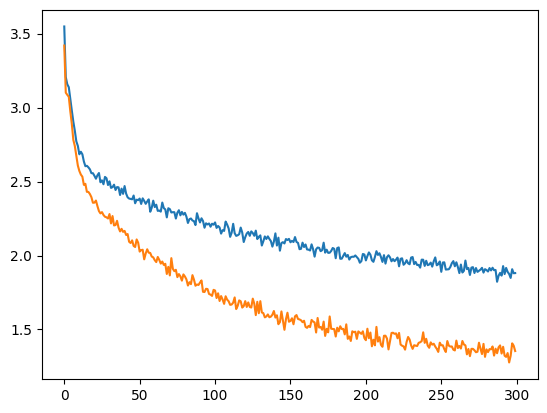

In [28]:
plt.plot(all_losses_rnn)
plt.plot(all_losses_lstm)

In [44]:
samples(model_lstm, [' '])

 A Neural Networks for Semantic Recognition ; The problem of a sensing and computer in the problem of a sensing and computer in the problem of a sensing and computer and the set of a sensing and computer and the statistical models and and and and and and 


In [65]:
samples(model_lstm, [' ', ' ', ' '], device=device, temperature=.5)

 Visual Neural Networks for Semantic Recognition and Insterative Method Semantic Recurrent Neural Networks ; We present a methods of the describing in a sentence and systems by represent a convolution results is a setection models. The very is a reastive co
 Processing Bayesian Approach for Metracting Reversion Senection ; This paper, and in the convolutional Neural Networks ; This paper, we present a semantic sparse a sparse a graphical many describe the pose of the restors and compress. The convention of nat
 Deep Research Expression Reconsing Detection ; A new and in the search of a support a natural proposed a market computer a new the process decomposed a performance in a simple results in research segmentation of predicting algorithm is the classification 


<a name="pytorch_lstm"></a>
## Pytorch LSTM Cell

In [28]:
64*256, batch_size*batch.shape[1]

(16384, 16448)

In [55]:
batch.size(), output.size()

(torch.Size([3, 257]), torch.Size([3, 257, 68]))

(torch.Size([771]), torch.Size([771, 68]))

tensor(5.5490, grad_fn=<NllLossBackward0>)

In [25]:
n_layers = 2
rnn = LSTMPytorch(n_letters, 128, n_letters, num_layers=n_layers)
hidden = (torch.randn(n_layers, 1, 128), torch.randn(n_layers, 1, 128))
criterion = nn.NLLLoss()
for i in range(label_line_tensor.size(0)):
      output, hidden = rnn(label_line_tensor[i].view(1, -1), hidden)
      l = criterion(output, target_line_tensor[i])

In [26]:
l, target_line_tensor[i], output[0, target_line_tensor[i][0]]

(tensor(4.3189, grad_fn=<NllLossBackward0>),
 tensor([0]),
 tensor(-4.3189, grad_fn=<SelectBackward0>))

<a name="lstm2_train_loop"></a>
### Цикл обучения

In [10]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [53]:
criterion = nn.NLLLoss()
learning_rate = 0.0005 * 2
model_lstm2 = LSTMPytorch(n_letters, 128, n_letters, num_layers=2).to(device)
opt = torch.optim.Adam(model_lstm2.parameters(), lr=learning_rate)

In [54]:
samples(model_lstm2, [' '], device=device, add_dim=True)

  Uss4yyyyyUyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyyy


In [57]:
samples(model_lstm2, [' '], device=device, add_dim=True, temperature=1)

 zv;ISnRW5.KHXbrawFhiJzwSZtb0jizfo6 IubTWXud XzlZV8UwsCwwokZdvRn omRNhhynVtEc0JjIQmj5,ljq 4JdaFH90'LV8xnL3J0Mbxvr9k94


In [58]:
n_iters = 15000
print_every = 50 * 4
plot_every = 50
all_losses_lstm2 = []
total_loss = 0 # Reset every ``plot_every`` ``iters``

start = time.time()

for iter in range(1, n_iters + 1):
    line = random_training_line()
    x, y = label_tensor(line), target_tensor(line)

    hidden = model_lstm2.init_hidden(device=device)
    output, loss = train(model_lstm2, opt, x.to(device), y.to(device), hidden, add_dim=True)
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % (time_since(start), iter, iter / n_iters * 100, loss))

    if iter % plot_every == 0:
        all_losses_lstm2.append(total_loss / plot_every)
        total_loss = 0

0m 49s (200 1%) 2.4128
1m 39s (400 2%) 2.1179
2m 30s (600 4%) 2.0815
3m 20s (800 5%) 1.7960
4m 11s (1000 6%) 1.6185
5m 2s (1200 8%) 1.7510
5m 52s (1400 9%) 1.6831
6m 44s (1600 10%) 1.3472
7m 34s (1800 12%) 1.7713
8m 25s (2000 13%) 1.6224
9m 16s (2200 14%) 2.2523
10m 6s (2400 16%) 1.6326
10m 56s (2600 17%) 1.5546
11m 47s (2800 18%) 1.6211
12m 37s (3000 20%) 1.4274
13m 27s (3200 21%) 1.8091
14m 17s (3400 22%) 1.7720
15m 8s (3600 24%) 1.2979
16m 0s (3800 25%) 1.3376
16m 52s (4000 26%) 1.3944
17m 43s (4200 28%) 1.2420
18m 33s (4400 29%) 1.3569
19m 26s (4600 30%) 1.2624
20m 17s (4800 32%) 1.3918
21m 8s (5000 33%) 1.2123
21m 59s (5200 34%) 1.4549
22m 50s (5400 36%) 1.3472
23m 42s (5600 37%) 1.4645
24m 34s (5800 38%) 1.5564
25m 24s (6000 40%) 1.2514
26m 16s (6200 41%) 1.4642
27m 7s (6400 42%) 1.4449
27m 59s (6600 44%) 1.6129
28m 50s (6800 45%) 1.4290
29m 42s (7000 46%) 1.5923
30m 34s (7200 48%) 1.6352
31m 26s (7400 49%) 1.2397
32m 18s (7600 50%) 1.1997
33m 9s (7800 52%) 1.3174
34m 2s (8000 53

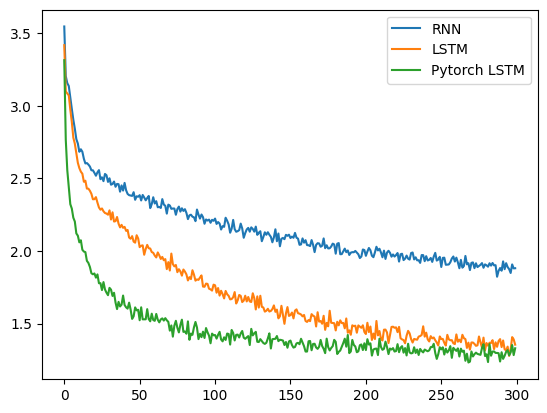

In [59]:
plt.plot(all_losses_rnn)
plt.plot(all_losses_lstm)
plt.plot(all_losses_lstm2)
plt.legend(['RNN', 'LSTM', 'Pytorch LSTM']);

In [60]:
samples(model_lstm2, [' '], device=device, add_dim=True)

 A Nonetic segmentation of the problem of the problem of the problem of the problem of the problem of the problem of the problem of the problem of the problem of the problem of the problem of the problem of the problem of the problem of the problem of the p


In [61]:
samples(model_lstm2, [' ', ' ', ' '], device=device, add_dim=True, temperature=.5)

 Method the problem to the performance and Speech Recognition of Selection of accurate and Constructions with Mining the symbolic contention with Algorithm for delevant analysis on particular do the computer vises of the true as a set of the problem of the 
 A Review of a network in entity and comprehension method for computing and construction but provides ; This paper preserving the structure Deep Neural networks ; We conditions ; We study on the proposed on the spectral Language Intere algorithms based on C
 Learning and regularized models ; Convolutional fundament a linear solving the an increasing Robust computing programming by learning ; Networks ; As an incorporate and nonnegation to continuous to and Gaussian Low process ; The problem in research and Mar


  ## Pytorch LSTM cell with batching

In [21]:
from time import time
from random import sample
from IPython.display import clear_output

In [11]:
def to_matrix(lines, max_len=None, pad=all_letters.find(EOS), dtype=np.int64):
    """Casts a list of lines into torch-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.full([len(lines), max_len], pad, dtype=dtype)
    for i in range(len(lines)):
        line_ix = list(map(all_letters.find, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

In [12]:
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
dummy_input_ix = torch.as_tensor(to_matrix(dummy_lines))
dummy_input_ix

tensor([[ 1, 42, 43, 44,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 42, 43, 42, 44, 42, 43, 42,  0,  0,  0,  0,  0,  0,  0],
        [ 1, 42, 43, 44,  6,  7,  8,  9, 10, 11, 12, 13, 14,  5,  0]])

In [13]:
class LSTMPytorch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMPytorch, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.rnn = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
        # self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_seq, hidden_state):
        emb = self.encoder(input_seq.long())
        # emb = input_seq
        output, hidden_state = self.rnn(emb, hidden_state)
        output = self.decoder(output)
        # output = self.softmax(output.squeeze(0))
        output = output.squeeze(0)
        return output, (hidden_state[0].detach(), hidden_state[1].detach())

    def init_hidden(self, batch_size, device=torch.device('cpu')):
        hidden = (
            torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device),
            torch.zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        return hidden

In [14]:
def get_possible_next_tokens(model, prefix=BOS, temperature=1.0, max_len=100, device=torch.device('cpu')):
    """ Get probabilities of next token, dict {token : prob} for all tokens """
    hidden = model.init_hidden(1, device=device)
    prefix_ix = torch.as_tensor(to_matrix([prefix]), dtype=torch.int64).to(device)
    with torch.no_grad():
        output, _ = model(prefix_ix, hidden)
        probs = torch.softmax(output[-1], dim=-1).cpu().numpy()
    return dict(zip(all_letters, probs))

def generate(model, prefix=BOS, temperature=1.0, max_len=100, device=torch.device('cpu')):
    """
    Samples output sequence from probability distribution obtained by model.
    Samples proportionally to model probabilities ^ temperature
        if temperature == 0, always takes most likely token.
    """
    with torch.no_grad():
        while True:
            token_probs = get_possible_next_tokens(model, prefix, device=device)
            tokens, probs = zip(*token_probs.items())
            if temperature == 0:
                next_token = tokens[np.argmax(probs)]
            else:
                probs = np.array([p ** (1. / temperature) for p in probs])
                probs /= sum(probs)
                next_token = np.random.choice(tokens, p=probs)

            prefix += next_token
            if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [15]:
def get_loss(model, batch, device):
    hidden = model.init_hidden(batch_size, device=device)
    x, y = batch[:, :-1], batch[:, 1:]
    output, _ = model(x, hidden)
    loss = criterion(output.reshape(batch_size*output.shape[1], n_letters), y.flatten())
    return loss

def score_lines(model, dev_lines, batch_size, device=torch.device('cpu')):
    dev_loss_num, dev_loss_len = 0., 0.
    with torch.no_grad():
        for i in range(0, len(dev_lines), batch_size):
            batch_ix = torch.as_tensor(to_matrix(dev_lines[i: i + batch_size]), device=device)
            dev_loss_num += get_loss(model, batch_ix, device=device).item() * len(batch_ix)
            dev_loss_len += len(batch_ix)
    return dev_loss_num / dev_loss_len

In [16]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
# device = torch.device('cpu')
device

device(type='cuda')

In [17]:
criterion = nn.CrossEntropyLoss()

In [18]:
batch_size = 256
n_layers = 2
learning_rate = 1e-3
rnn = LSTMPytorch(n_letters, 256, n_letters, num_layers=n_layers).to(device)
opt = torch.optim.Adam(rnn.parameters(), lr=learning_rate)

In [20]:
generate(rnn, device=device)

' eYCTe\n'

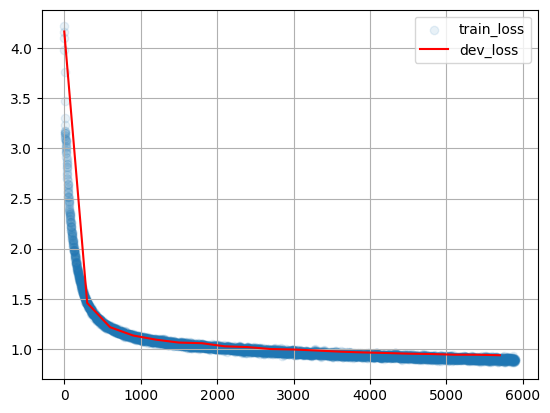

[5900] loss: 0.899, elapsed: 1003.2


In [22]:
t0 = time()
print_every = 100
score_dev_every = 300
train_history, dev_history = [], []

for i in range(6000):
    opt.zero_grad()
    hidden = rnn.init_hidden(batch_size, device=device)
    batch = torch.as_tensor(to_matrix(sample(lines, batch_size)), device=device)
    loss = get_loss(rnn, batch, device)
    loss.backward()
    opt.step()

    train_history.append((i, loss.item()))

    if i % print_every == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print(f'[{i}] loss: {loss.item():.3f}, elapsed: {time() - t0:.1f}')

    if (i) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(rnn, dev_lines[:1024], batch_size, device=device)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
        print("Generated examples:")
        for _ in range(3):
            print(generate(rnn, device=device))

In [23]:
generate(rnn, device=device)

' A Generalized TheRow the Equation in General EScharge Models ; In the arithore tail describing the O'

In [25]:
torch.save(rnn.state_dict(), 'lstm_arxiv_lm.pth')

Обученная модель вручную была загружена на HF hub - загрузим её в память, чтобы поэкспериментировать

In [26]:
!wget https://huggingface.co/sswt/lstm_arxiv_lm/resolve/main/lstm_arxiv_lm.pth -O lstm_arxiv_lm.pth

--2023-10-05 11:17:15--  https://huggingface.co/sswt/lstm_arxiv_lm/resolve/main/lstm_arxiv_lm.pth
Resolving huggingface.co (huggingface.co)... 3.163.180.117, 3.163.180.94, 3.163.180.7, ...
Connecting to huggingface.co (huggingface.co)|3.163.180.117|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/c4/4e/c44ebb1dee20b2a291b2447695dbb88a52d2896dc1d816643da8d72755d848ae/f2f174b6f96eea995937683b4f47ca38da347ee8f3bd14a47a504c38ac562552?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27lstm_arxiv_lm.pth%3B+filename%3D%22lstm_arxiv_lm.pth%22%3B&Expires=1696763835&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTY5Njc2MzgzNX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9yZXBvcy9jNC80ZS9jNDRlYmIxZGVlMjBiMmEyOTFiMjQ0NzY5NWRiYjg4YTUyZDI4OTZkYzFkODE2NjQzZGE4ZDcyNzU1ZDg0OGFlL2YyZjE3NGI2Zjk2ZWVhOTk1OTM3NjgzYjRmNDdjYTM4ZGEzNDdlZThmM2JkMTRhNDdhNTA0YzM4YWM1NjI1NTI%7Ecm

In [27]:
trained_model = LSTMPytorch(n_letters, 256, n_letters, num_layers=n_layers)
trained_model.load_state_dict(torch.load('lstm_arxiv_lm.pth'))
trained_model.to(device)
trained_model.eval()

LSTMPytorch(
  (encoder): Embedding(68, 256)
  (rnn): LSTM(256, 256, num_layers=2, batch_first=True)
  (decoder): Linear(in_features=256, out_features=68, bias=True)
)

In [30]:
for i in range(3):
    print(generate(trained_model, device=device))

 Towards Economic Sair Estimation for Internet the Levy Motivated Euclidean Finance ; In a multimodal
 On Regularized ImC Grouptext Theory ; The Kuramoto model for a simplified backdoor hard gome kinemat
 Efficient Einstein Stories Do Neutrino Masses in SUSY B13 ; The similarity of themArtimetrise in the


LSTM-сети были большим шагом к усовершенствованию классических RNN и после их появления ещё было много улучшений (peephole, GRU и т.д.).
Но ключевой следующий шаг развития был ещё значимее - появление attention. Механизм внимания позволяет обращать внимание на большИй контекст.

## Упражнения

* попробуйте ограничить градиенты или веса в обычной RNN, чтобы она обучалась на последовательностях длины 512
* попробуйте GRU вместо LSTM
* попробуйте реализовать различные стратегии сэмплирования - top-K, BeamSearch
* добавьте бинарную маску при расчёте loss в последней сети, чтобы не считать ошибку по хвостам поседовательностей, когда они выровняны под конечную длину